<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import gensim
import re
import pyLDAvis.gensim

from collections import Counter
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora

/home/jay/anaconda3/envs/nlp-u4-s1/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [2]:
# Where am i?
%pwd

'/home/jay/Desktop/school_projects/lambda_repos/DS-Unit-4-Sprint-1-NLP/module4-topic-modeling'

In [3]:
# read in our amazon reviews csv
df = pd.read_csv('../module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

print(df.shape)

df.head()

(28332, 24)


id             dateAdded           dateUpdated  \
0  AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   
1  AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   
2  AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   
3  AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   
4  AVpgNzjwLJeJML43Kpxn  2015-10-30T08:59:32Z  2019-04-25T09:08:16Z   

                                                name                  asins  \
0  AmazonBasics AAA Performance Alkaline Batterie...  B00QWO9P0O,B00LH3DMUO   
1  AmazonBasics AAA Performance Alkaline Batterie...  B00QWO9P0O,B00LH3DMUO   
2  AmazonBasics AAA Performance Alkaline Batterie...  B00QWO9P0O,B00LH3DMUO   
3  AmazonBasics AAA Performance Alkaline Batterie...  B00QWO9P0O,B00LH3DMUO   
4  AmazonBasics AAA Performance Alkaline Batterie...  B00QWO9P0O,B00LH3DMUO   

          brand                                         categories  \
0  Amazonbasics  AA,AAA,Health,Electronics,Health & Household,C...   
1  Amazonbasics  AA,AAA,Health,Electronics,Health & Household,C...   
2  Amazonbasics  AA,AAA,Health,Electronics,Health & Household,C...   
3  Amazonbasics  AA,AAA,Health,Electronics,Health & Household,C...   
4  Amazonbasics  AA,AAA,Health,Electronics,Health & Household,C...   

  primaryCategories                                          imageURLs  \
0   Health & Beauty  https://images-na.ssl-images-amazon.com/images...   
1   Health & Beauty  https://images-na.ssl-images-amazon.com/images...   
2   Health & Beauty  https://images-na.ssl-images-amazon.com/images...   
3   Health & Beauty  https://images-na.ssl-images-amazon.com/images...   
4   Health & Beauty  https://images-na.ssl-images-amazon.com/images...   

                                                keys  ... reviews.didPurchase  \
0  amazonbasics/hl002619,amazonbasicsaaaperforman...  ...                 NaN   
1  amazonbasics/hl002619,amazonbasicsaaaperforman...  ...                 NaN   
2  amazonbasics/hl002619,amazonbasicsaaaperforman...  ...                 NaN   
3  amazonbasics/hl002619,amazonbasicsaaaperforman...  ...                 NaN   
4  amazonbasics/hl002619,amazonbasicsaaaperforman...  ...                 NaN   

  reviews.doRecommend reviews.id reviews.numHelpful reviews.rating  \
0                 NaN        NaN                NaN              3   
1                 NaN        NaN                NaN              4   
2                 NaN        NaN                NaN              5   
3                 NaN        NaN                NaN              5   
4                 NaN        NaN                NaN              5   

                                  reviews.sourceURLs  \
0  https://www.amazon.com/product-reviews/B00QWO9...   
1  https://www.amazon.com/product-reviews/B00QWO9...   
2  https://www.amazon.com/product-reviews/B00QWO9...   
3  https://www.amazon.com/product-reviews/B00QWO9...   
4  https://www.amazon.com/product-reviews/B00QWO9...   

                                        reviews.text  \
0  I order 3 of them and one of the item is bad q...   
1  Bulk is always the less expensive way to go fo...   
2  Well they are not Duracell but for the price i...   
3  Seem to work as well as name brand batteries a...   
4  These batteries are very long lasting the pric...   

                                       reviews.title  reviews.username  \
0  ... 3 of them and one of the item is bad quali...        Byger yang   
1  ... always the less expensive way to go for pr...              ByMG   
2  ... are not Duracell but for the price i am ha...  BySharon Lambert   
3  ... as well as name brand batteries at a much ...     Bymark sexson   
4  ... batteries are very long lasting the price ...           Bylinda   

                                          sourceURLs  
0  https://www.barcodable.com/upc/841710106442,ht...  
1  https://www.barcodable.com/upc/841710106442,ht...  
2  https://www.barcodable.com/upc/841710106442,ht...  
3  htt

In [20]:
# tokenize f(x)
def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

# f(x) to create a word count df for visualizations
def count(docs):
    
    word_counts = Counter()
    appears_in = Counter()
    
    total_docs = len(docs)
    
    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))
        
    temp = zip(word_counts.keys(), word_counts.values())
    
    wc = pd.DataFrame(temp, columns=['word', 'count'])
    
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()
    
    wc['pct_total'] = wc['count'].apply(lambda x: x / total)
    
    wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()
    
    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')
    
    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
    
    return wc.sort_values(by='rank')

# Coherence Model f(x)
def compute_coherence_values(dictionary, corpus, tokens, limit, start=2, step=3, passes=5):
    
    coherence_values = []
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model, dictionary=dictionary, corpus=corpus, coherence='u_mass')
            coherence_values.append({
                'pass': iter_,
                'num_topics': num_topics,
                'coherence_score': coherencemodel.get_coherence()
            })
            
    return coherence_values

In [5]:
df.columns

Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs'],
      dtype='object')

In [6]:
# get a list of the tokens for each review
data = []

for val in df['reviews.text']:
    val_tokens = tokenize(val)
    data.append(val_tokens)

In [7]:
# new column with tokens
df['tokens'] = data

In [8]:
# create dict of tokens
id2word = corpora.Dictionary(df['tokens'])

In [9]:
# find some words we know are in there
id2word.token2id['great']

22

In [10]:
# Curiously its not larger than the 56 from the docstream shown in class
import sys
sys.getsizeof(id2word)

56

In [11]:
# check how many keys in dict
len(id2word.keys())

9622

In [12]:
# filter out extremes
id2word.filter_extremes(no_below=20, no_above=.95)

In [13]:
# see how much smaller it is
len(id2word.keys())

1574

In [14]:
# corpus for lda
corpus = [id2word.doc2bow(doc) for doc in df['tokens']]

In [21]:
# run lda
lda = LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    random_state=424242,
    num_topics=5,
    passes=10,
    workers=4
)

/home/jay/anaconda3/envs/nlp-u4-s1/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jay/anaconda3/envs/nlp-u4-s1/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jay/anaconda3/envs/nlp-u4-s1/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


In [22]:
# topics look pretty good at a glance
lda.print_topics()

[(0,
  '0.051*"tablet" + 0.026*"kids" + 0.022*"apps" + 0.022*"games" + 0.020*"use" + 0.017*"amazon" + 0.017*"great" + 0.015*"love" + 0.015*"play" + 0.013*"year"'),
 (1,
  '0.051*"kindle" + 0.028*"bought" + 0.026*"love" + 0.017*"loves" + 0.017*"use" + 0.014*"old" + 0.014*"read" + 0.014*"new" + 0.013*"easy" + 0.011*"got"'),
 (2,
  '0.100*"great" + 0.064*"tablet" + 0.055*"price" + 0.035*"good" + 0.025*"product" + 0.019*"works" + 0.019*"gift" + 0.016*"bought" + 0.014*"christmas" + 0.013*"recommend"'),
 (3,
  '0.091*"batteries" + 0.038*"good" + 0.027*"price" + 0.026*"long" + 0.026*"great" + 0.025*"work" + 0.020*"amazon" + 0.016*"battery" + 0.015*"brand" + 0.013*"buy"'),
 (4,
  '0.036*"easy" + 0.031*"use" + 0.027*"nice" + 0.025*"great" + 0.023*"screen" + 0.022*"battery" + 0.016*"old" + 0.016*"size" + 0.015*"perfect" + 0.013*"life"')]

In [23]:
# for practicing regex and getting a feel for this transformation to a prettier printout
words = [re.findall('"([^"]*)"', t[1]) for t in lda.print_topics()]

topics = [' '.join(t) for t in words]

for id, t in enumerate(topics):
    print(f'----- Topic {id} -----')
    print(t, end='\n\n')

----- Topic 0 -----
tablet kids apps games use amazon great love play year

----- Topic 1 -----
kindle bought love loves use old read new easy got

----- Topic 2 -----
great tablet price good product works gift bought christmas recommend

----- Topic 3 -----
batteries good price long great work amazon battery brand buy

----- Topic 4 -----
easy use nice great screen battery old size perfect life



In [24]:
pyLDAvis.enable_notebook()


pyLDAvis.gensim.prepare(lda, corpus, id2word)

/home/jay/anaconda3/envs/nlp-u4-s1/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.252358 -0.094260       1        1  27.966339
0     -0.095014  0.077773       2        1  26.269398
1     -0.122547 -0.090321       3        1  16.745148
2      0.059991  0.195325       4        1  16.078556
4     -0.094788 -0.088518       5        1  12.940561, topic_info=     Category         Freq       Term        Total  loglift  logprob
16    Default  7343.000000  batteries  7343.000000  30.0000  30.0000
1337  Default  6907.000000     tablet  6907.000000  29.0000  29.0000
19    Default  8938.000000      great  8938.000000  28.0000  28.0000
15    Default  4862.000000      price  4862.000000  27.0000  27.0000
1229  Default  3133.000000     kindle  3133.000000  26.0000  26.0000
602   Default  3143.000000       easy  3143.000000  25.0000  25.0000
31    Default  5781.000000       good  5781.000000  24.0000  24.0000
2     Default  2165.000000    battery  2165.000000  23.0000  23.0000
525   Default  1695.000000      games  1695.000000  22.0000  22.0000
1035  Default  1783.000000       apps  1783.000000  21.0000  21.0000
163   Default  1244.000000       nice  1244.000000  20.0000  20.0000
21    Default  2461.000000       long  2461.000000  19.0000  19.0000
7     Default  2333.000000       work  2333.000000  18.0000  18.0000
18    Default  1249.000000      brand  1249.000000  17.0000  17.0000
176   Default  2453.000000       kids  2453.000000  16.0000  16.0000
691   Default  1131.000000       gift  1131.000000  15.0000  15.0000
150   Default  1922.000000    product  1922.000000  14.0000  14.0000
430   Default  2287.000000        old  2287.000000  13.0000  13.0000
343   Default  1111.000000       play  1111.000000  12.0000  12.0000
1085  Default  1751.000000     screen  1751.000000  11.0000  11.0000
88    Default  1417.000000      works  1417.000000  10.0000  10.0000
25    Default  3253.000000     bought  3253.000000   9.0000   9.0000
28    Default   937.000000  christmas   937.000000   8.0000   8.0000
86    Default  4556.000000        use  4556.000000   7.0000   7.0000
71    Default   852.000000     brands   852.000000   6.0000   6.0000
97    Default  1846.000000       year  1846.000000   5.0000   5.0000
56    Default  1066.000000       life  1066.000000   4.0000   4.0000
1159  Default  2333.000000      loves  2333.000000   3.0000   3.0000
45    Default  1155.000000    perfect  1155.000000   2.0000   2.0000
83    Default  3541.000000       love  3541.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
602    Topic5  1334.811768       easy  3143.745850   1.1882  -3.3293
974    Topic5   148.416382     weight   216.248169   1.6684  -5.5258
45     Topic5   546.635132    perfect  1155.494385   1.2963  -4.2221
842    Topic5   110.988632      hands   153.739044   1.7190  -5.8164
2      Topic5   802.298584    battery  2165.681641   1.0518  -3.8384
56     Topic5   472.694366       life  1066.947632   1.2307  -4.3674
393    Topic5   263.243134      small   503.363556   1.3966  -4.9528
1171   Topic5    88.993027    buttons   115.543762   1.7837  -6.0373
86     Topic5  1146.606079        use  4556.169922   0.6651  -3.4813
197    Topic5   264.672363     charge   558.646606   1.2978  -4.9473
103    Topic5   239.703384     needed   492.902588   1.3239  -5.0464
248    Topic5   338.851654       case   845.872437   1.1300  -4.7003
430    Topic5   613.095154        old  2287.000000   0.7283  -4.1073
984    Topic5   135.786652     laptop   216.197906   1.5797  -5.6148
50     Topic5   172.108734       hold   335.946899   1.3760  -5.3777
1040   Topic5   165.667725      phone   319.443359   1.3882  -5.4159
19     Topic5   928.075195      great  8938.206055  -0.2202  -3.6927
214    Topic5   300.485779     device  1024.012085   0.8187  -4.8204
10     Topic5   433.958557       like  2514.093750   0.2881  -4.4529
150    Topic5   359.254456    product  1922.965332   0.3672 

5 topics is pretty good. 2 overlap so 4 intuitively seems like it will be correct. 

In [25]:
coherence_values = compute_coherence_values(
                                dictionary=id2word,
                                corpus=corpus,
                                tokens=df['tokens'],
                                limit=15,
                                step=2
                                )

/home/jay/anaconda3/envs/nlp-u4-s1/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jay/anaconda3/envs/nlp-u4-s1/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jay/anaconda3/envs/nlp-u4-s1/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


In [26]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

In [27]:
topic_coherence.head(20)

coherence_score  num_topics  pass
0         -2.562457           2     0
1         -2.592126           4     0
2         -2.574123           6     0
3         -2.701326           8     0
4         -2.661492          10     0
5         -2.624493          12     0
6         -2.733061          14     0
7         -2.581645           2     1
8         -2.609344           4     1
9         -2.597309           6     1
10        -2.585747           8     1
11        -2.673110          10     1
12        -2.569400          12     1
13        -2.695391          14     1
14        -2.511270           2     2
15        -2.612391           4     2
16        -2.565071           6     2
17        -2.674104           8     2
18        -2.706517          10     2
19        -2.678169          12     2

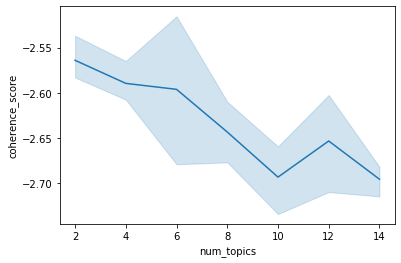

In [29]:
sns.lineplot(x='num_topics', y='coherence_score', data=topic_coherence);

- the pyLDAvis shows 4 nice looking separate bubbles, the two overlapping could be reduced to 1 likely

- however the lineplot shows a steadily decreasing score as topics increase up to 12

- the topics from looking at the words look very good
-- theres a topic of people enjoying it as a christmas gift
-- a topic of people saying their kids like it for playing games
-- the overlapping topics both talk about the battery life being good, one also says the screen is good

In [ ]:
wc = count(df['tokens'])

wc.head(20)

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling